In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder, Normalizer, Binarizer
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/dataset_damin/

/content/drive/My Drive/dataset_damin


In [3]:
train = pd.read_csv('train.csv', delimiter="|")
df = train.copy()
test = pd.read_csv('test.csv', delimiter="|")
data_test = test.copy()
df.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [4]:
data_test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [5]:
df.iloc[173]

trustLevel                    6.00
totalScanTimeInSeconds        2.00
grandTotal                   75.74
lineItemVoids                 6.00
scansWithoutRegistration      1.00
quantityModifications         1.00
scannedLineItemsPerSecond     4.00
valuePerSecond               37.87
lineItemVoidsPerPosition      0.75
fraud                         0.00
Name: 173, dtype: float64

In [6]:
print(df.isnull().values.any())
print(data_test.isnull().values.any())

False
False


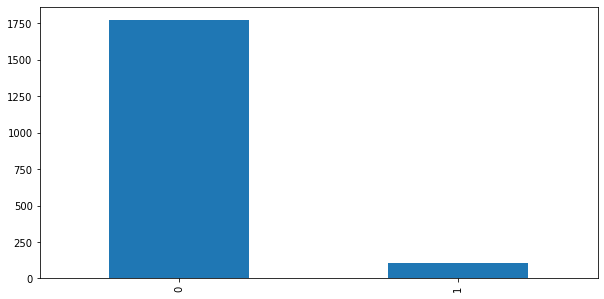

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['fraud'].value_counts().plot(kind='bar', ax=ax1)
plt.show() 

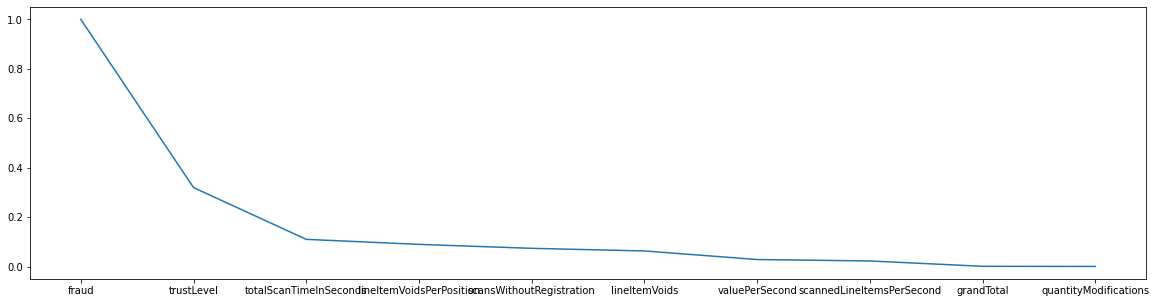

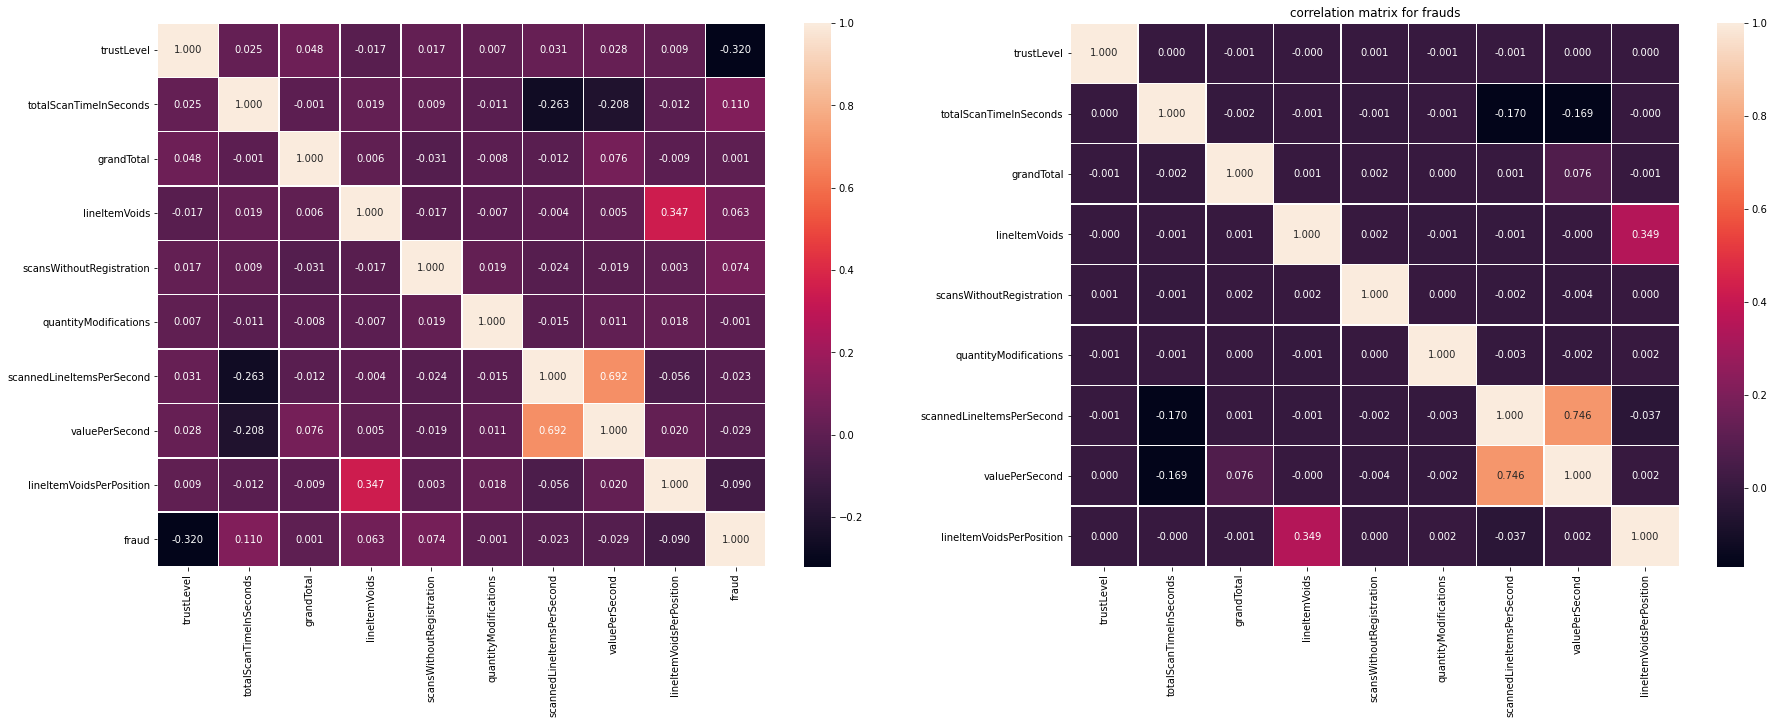

fraud                        1.000000
trustLevel                   0.319765
totalScanTimeInSeconds       0.110414
lineItemVoidsPerPosition     0.090116
scansWithoutRegistration     0.074123
lineItemVoids                0.063496
valuePerSecond               0.028873
scannedLineItemsPerSecond    0.023085
grandTotal                   0.001421
quantityModifications        0.000864
Name: fraud, dtype: float64


In [8]:
numeric_features = df.select_dtypes(include=[np.number])
numeric_features.columns
correlation = numeric_features.corr()
korelasi = correlation['fraud'].sort_values(ascending = False)
for i in range(len(korelasi)):
  if(korelasi[i] < 0):
    korelasi[i]  = korelasi[i]  * (-1)
plt.figure(figsize=(20,5))
plt.plot(korelasi.sort_values(ascending = False))
korelasi = korelasi.sort_values(ascending = False)
f,ax = plt.subplots(figsize=(30, 10), ncols=2)
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax[0])
sns.heatmap(data_test.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax[1])

plt.title("correlation matrix for frauds")
plt.show()
print(korelasi)


fraud                        1.000000
trustLevel                   0.319765
totalItem                    0.298423
totalScanTimeInSeconds       0.110414
lineItemVoidsPerPosition     0.090116
scansWithoutRegistration     0.074123
lineItemVoids                0.063496
valuePerSecond               0.028873
scannedLineItemsPerSecond    0.023085
grandTotal                   0.001421
quantityModifications        0.000864
Name: fraud, dtype: float64


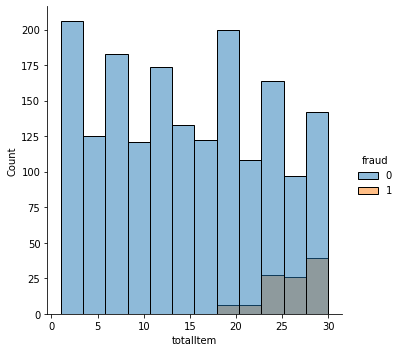

In [9]:

df['totalItem'] = train.totalScanTimeInSeconds * train.scannedLineItemsPerSecond
# df['valuePerItem'] = train.valuePerSecond / df.scannedLineItemsPerSecond
# df['total_item'] = df.total_item - (train.scansWithoutRegistration * train.scannedLineItemsPerSecond)
# df = df.drop(['quantityModifications','grandTotal','scannedLineItemsPerSecond','valuePerSecond','lineItemVoids'],axis=1)
# df['fet1'] =  (train.lineItemVoids * train.lineItemVoidsPerPosition)
# df['fet1'] =  (train.totalScanTimeInSeconds * train.valuePerSecond)
# df['fet2'] = (train.totalScanTimeInSeconds * train.valuePerSecond.pow(2))
# df['fet2'] = (train.totalScanTimeInSeconds * train.valuePerSecond.pow(3.5))


data_test['totalItem'] = test.totalScanTimeInSeconds * test.scannedLineItemsPerSecond
# data_test['valuePerItem'] = test.valuePerSecond / data_test.scannedLineItemsPerSecond
# data_test['total_item'] = test.totalScanTimeInSeconds * test.scannedLineItemsPerSecond
# data_test['total_item'] = data_test.total_item - (test.scansWithoutRegistration * test.scannedLineItemsPerSecond)
# data_test = data_test.drop(['quantityModifications','grandTotal','scannedLineItemsPerSecond','valuePerSecond','lineItemVoids'],axis=1)
# data_test['fet1'] =  (test.lineItemVoids * test.lineItemVoidsPerPosition)
# data_test['fet1'] =  (test.totalScanTimeInSeconds * test.valuePerSecond)
# data_test['fet2'] = (test.totalScanTimeInSeconds * test.valuePerSecond.pow(2))
# data_test['fet2'] = (test.totalScanTimeInSeconds * test.valuePerSecond.pow(3.5))

# df = df.drop(['grandTotal', 'quantityModifications'], axis=1)
# data_test = data_test.drop(['grandTotal', 'quantityModifications'], axis=1)
# df.totalScanTimeInSeconds = pd.to_numeric(df.totalScanTimeInSeconds, downcast='float')

# sns.displot(df, x="total_item", hue="fraud")
numeric_features = df.select_dtypes(include=[np.number])
numeric_features.columns
correlation = numeric_features.corr()
korelasi = correlation['fraud'].sort_values(ascending = False)
for i in range(len(korelasi)):
  if(korelasi[i] < 0):
    korelasi[i]  = korelasi[i]  * (-1)
korelasi = korelasi.sort_values(ascending = False)
sns.displot(df, x="totalItem", hue="fraud")
print(korelasi)

In [10]:
df.dtypes

trustLevel                     int64
totalScanTimeInSeconds         int64
grandTotal                   float64
lineItemVoids                  int64
scansWithoutRegistration       int64
quantityModifications          int64
scannedLineItemsPerSecond    float64
valuePerSecond               float64
lineItemVoidsPerPosition     float64
fraud                          int64
totalItem                    float64
dtype: object

In [11]:
for i in (np.sort(df.trustLevel.unique())):
  print(i)
  print(df[df.trustLevel == i].fraud.value_counts())

1
0    243
1     89
Name: fraud, dtype: int64
2
0    332
1     15
Name: fraud, dtype: int64
3
0    318
Name: fraud, dtype: int64
4
0    289
Name: fraud, dtype: int64
5
0    302
Name: fraud, dtype: int64
6
0    291
Name: fraud, dtype: int64


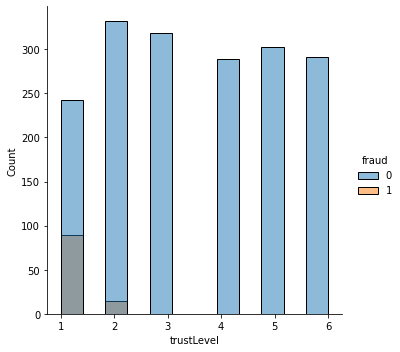

In [12]:
sns.displot(df, x="trustLevel", hue="fraud")

Maka mendapat pola untuk trustLevel > 2 | fraud = (0), trustLevel <=2  | fraud = (0,1)

Model klasifikasi ditunjukkan untuk trustLevel <= 2

In [13]:
# df_new = df[df.trustLevel <=2 ]
# df_new

In [14]:
X, y = df.loc[:, df.columns != 'fraud'], df.fraud

In [15]:
# scaler = StandardScaler()
# scaler = scaler.fit(X)
# X = scaler.transform(X)

In [16]:
X

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalItem
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,29.0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,14.0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,13.0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,29.0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,27.0
...,...,...,...,...,...,...,...,...,...,...
1874,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,23.0
1875,1,397,41.89,5,5,0,0.065491,0.105516,0.192308,26.0
1876,4,316,41.83,5,8,1,0.094937,0.132373,0.166667,30.0
1877,2,685,62.68,1,6,2,0.035036,0.091504,0.041667,24.0


In [17]:
X_train_o, X_valid_o, y_train_o, y_valid_o = train_test_split(X, y, test_size=0.2, random_state=13)

In [18]:
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, SVMSMOTE, BorderlineSMOTE, BorderlineSMOTE, SMOTENC
# oversample = SMOTENC(random_state=42, categorical_features=[0,2,3])
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train_o, y_train_o)
# X_train, y_train = X_train_o, y_train_o

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


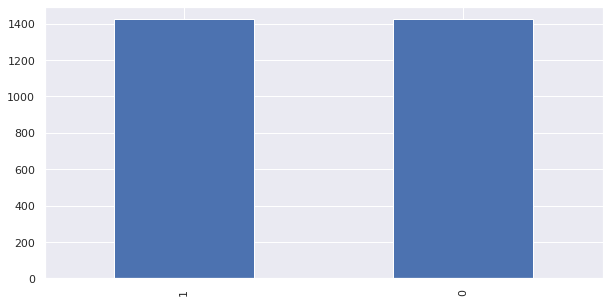

In [32]:
# fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
# y_train.value_counts.plot(kind='bar', ax=ax1)
# plt.show()
fraud_df_train = pd.DataFrame(data=y_train, columns=['fraud'])
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
fraud_df_train.fraud.value_counts().plot(kind='bar', ax=ax1)
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,StackingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, BalancedBaggingClassifier
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24

In [21]:
estimators = [
('gbc', GradientBoostingClassifier(random_state=42)),
('svr', SVC(gamma='auto', kernel='linear', C=0.5, random_state=1))
]
classifiers = [
    KNeighborsClassifier(5),
    SVC(gamma='auto', kernel='linear', C=0.3),
    LinearSVC(random_state=42),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    # ExtraTreesClassifier(),
    # StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier()),
    GaussianNB(),
    BalancedBaggingClassifier(random_state=42),
    RUSBoostClassifier(random_state=0),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
]

In [22]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
target_names = list(df['fraud'].unique())
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_valid_o)
    acc = accuracy_score(y_valid_o, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_valid_o.to_numpy().ravel(), train_predictions, labels=target_names))
    if name != 'SVC' and name != 'VotingClassifier' and name != 'LinearSVC':
      train_predictions = clf.predict_proba(X_valid_o)
    
    ll = log_loss(y_valid_o, train_predictions)
    print("Log Loss: {}".format(ll))
    
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 74.7340%
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       352
           1       0.11      0.42      0.17        24

    accuracy                           0.75       376
   macro avg       0.53      0.59      0.51       376
weighted avg       0.90      0.75      0.81       376

Log Loss: 3.038136398813632
SVC
****Results****
Accuracy: 99.7340%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       352
           1       0.96      1.00      0.98        24

    accuracy                           1.00       376
   macro avg       0.98      1.00      0.99       376
weighted avg       1.00      1.00      1.00       376

Log Loss: 0.09186057444771609


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
****Results****
Accuracy: 77.6596%
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       352
           1       0.22      0.96      0.35        24

    accuracy                           0.78       376
   macro avg       0.61      0.86      0.61       376
weighted avg       0.95      0.78      0.83       376

Log Loss: 7.716286127019159
DecisionTreeClassifier
****Results****
Accuracy: 97.8723%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       352
           1       0.81      0.88      0.84        24

    accuracy                           0.98       376
   macro avg       0.90      0.93      0.91       376
weighted avg       0.98      0.98      0.98       376

Log Loss: 0.734867582870441
RandomForestClassifier
****Results****
Accuracy: 98.1383%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       352
           1       0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

BalancedBaggingClassifier
****Results****
Accuracy: 98.6702%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       352
           1       0.91      0.88      0.89        24

    accuracy                           0.99       376
   macro avg       0.95      0.93      0.94       376
weighted avg       0.99      0.99      0.99       376

Log Loss: 0.11472730374537857
RUSBoostClassifier
****Results****
Accuracy: 97.6064%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       352
           1       0.76      0.92      0.83        24

    accuracy                           0.98       376
   macro avg       0.88      0.95      0.91       376
weighted avg       0.98      0.98      0.98       376

Log Loss: 0.8267260307292459
LinearDiscriminantAnalysis
****Results****
Accuracy: 87.7660%
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       352
 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


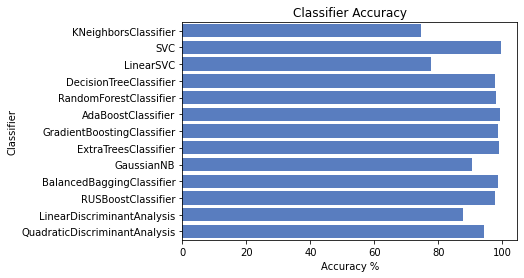

In [23]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
sns.set(rc={'figure.figsize':(5,10)})
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

# sns.set_color_codes("muted")
# sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

# plt.xlabel('Log Loss')
# plt.title('Classifier Log Loss')
# plt.show()

In [24]:
from sklearn.model_selection import KFold
model = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier())
model.fit(X_train, y_train)
print('****Results****')
train_predictions = model.predict(X_valid_o)
acc = accuracy_score(y_valid_o, train_predictions)
print("Accuracy: {:.4%}".format(acc))
print(classification_report(y_valid_o.to_numpy().ravel(), train_predictions, labels=target_names))
# kf = KFold(n_splits=10, random_state=1)
# kf.get_n_splits(X)
# for train_index, test_index in kf.split(X):
#   # print("TRAIN:", train_index, "TEST:", test_index)
#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]
#   model.fit(X_train, y_train)
#   print('****Results****')
#   train_predictions = model.predict(X_test)
#   acc = accuracy_score(y_test, train_predictions)
#   print("Accuracy: {:.4%}".format(acc))
#   # print(classification_report(y_test.to_numpy().ravel(), train_predictions, labels=target_names))
#   # train_predictions = model.predict_proba(X_test)
#   ll = log_loss(y_test, train_predictions)
#   print("Log Loss: {}".format(ll))
  


****Results****
Accuracy: 100.0000%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       352
           1       1.00      1.00      1.00        24

    accuracy                           1.00       376
   macro avg       1.00      1.00      1.00       376
weighted avg       1.00      1.00      1.00       376



In [25]:
data_test_trust1 = data_test[data_test.trustLevel <= 2]
data_test_trust2 = data_test[data_test.trustLevel > 2]



data_test_trust2['fraud'] = np.zeros(len(data_test_trust2), dtype=int)
X_test = data_test

# X_test = data_test_trust1
# X_test
# scaler_test = StandardScaler()
# scaler_test = scaler_test.fit(X_test)
# X_test = scaler_test.transform(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
predict_test = model.predict(X_test)
# prediction_file = pd.DataFrame(predict_test, columns=['predictions']).to_csv('prediction.csv')


In [27]:
# data_test_trust1['fraud'] = predict_test
# result = pd.concat([data_test_trust1,data_test_trust2])
# result = result.sort_index()

In [28]:
real_class = pd.read_csv('DMC-2019-realclass.csv', delimiter="|")
real_class.head()

,fraud
0,0
1,0
2,0
3,0
4,0


In [29]:
# print(classification_report(real_class.to_numpy().ravel(), result.fraud.to_numpy().ravel(), labels=target_names))
print(classification_report(real_class.to_numpy().ravel(), predict_test.ravel(), labels=target_names))
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
print_confusion_matrix(real_class.to_numpy().ravel(), predict_test.ravel())

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    474394
           1       0.89      0.92      0.91     23727

    accuracy                           0.99    498121
   macro avg       0.95      0.96      0.95    498121
weighted avg       0.99      0.99      0.99    498121

True positive =  471825
False positive =  2569
False negative =  1957
True negative =  21770
